In [3]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine, text
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

# Assuming the notebook is in 'notebooks/' and the project root is one level up
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to sys.path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# Verify the path has been added (optional)
print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: d:\Projects\EDA-Clustering-Time-series---Regression-Model-Airbnb-Data


In [4]:
from database import get_sqlalchemy_engine
engine = get_sqlalchemy_engine()

✅ Successfully connected to SQL Server via pyodbc.
✅ SQLAlchemy engine created successfully.


In [5]:
# Load full table
query = "SELECT * FROM listing_features"
df = pd.read_sql(query, engine)

print(f"✅ Loaded {len(df)} rows.")
print(df.info())
print(df.describe(include='all'))

✅ Loaded 1178740 rows.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1178740 entries, 0 to 1178739
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   listing_id              1178740 non-null  int64  
 1   total_weeks             1178740 non-null  int64  
 2   offline_weeks           1178740 non-null  int64  
 3   pct_offline_weeks       1178740 non-null  float64
 4   mean_availability       1178740 non-null  float64
 5   first_week              1178740 non-null  object 
 6   last_week               1178740 non-null  object 
 7   base_price              996981 non-null   float64
 8   number_of_reviews       1178740 non-null  int64  
 9   property_city           1178740 non-null  object 
 10  property_country        1178740 non-null  object 
 11  property_neighbourhood  1178740 non-null  object 
 12  latitude                1178740 non-null  float64
 13  longitude               1178740 no

In [6]:
# Filter dataset
df_filtered = df[
    (df['base_price'].notna()) &          # base_price is not null
    (df['base_price'] > 0) &             # base_price > 0
    (df['pct_offline_weeks'] < 1)        # not offline 100% of the year
].copy()

print(f"✅ Loaded {len(df_filtered)} rows.")
print(df_filtered.info())
print(df_filtered.describe(include='all'))

✅ Loaded 986250 rows.
<class 'pandas.core.frame.DataFrame'>
Index: 986250 entries, 0 to 1178738
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   listing_id              986250 non-null  int64  
 1   total_weeks             986250 non-null  int64  
 2   offline_weeks           986250 non-null  int64  
 3   pct_offline_weeks       986250 non-null  float64
 4   mean_availability       986250 non-null  float64
 5   first_week              986250 non-null  object 
 6   last_week               986250 non-null  object 
 7   base_price              986250 non-null  float64
 8   number_of_reviews       986250 non-null  int64  
 9   property_city           986250 non-null  object 
 10  property_country        986250 non-null  object 
 11  property_neighbourhood  986250 non-null  object 
 12  latitude                986250 non-null  float64
 13  longitude               986250 non-null  float64
 14  ho

In [7]:
features = [
    'base_price',          # Price level
    'mean_availability',   # Weekly availability
    'pct_offline_weeks',   # Host activeness
    'number_of_reviews',   # Popularity
    'review_scores_rating',# Quality perception
    'latitude', 'longitude' # Location
]


In [8]:
# Check NaN count and percentage for the selected features
nan_summary = df_filtered[features].isna().sum().to_frame('NaN_count')
nan_summary['NaN_%'] = 100 * nan_summary['NaN_count'] / len(df_filtered)

print("🧹 Missing values in selected features:")
display(nan_summary)


🧹 Missing values in selected features:


,NaN_count,NaN_%
base_price,0,0.000000
mean_availability,0,0.000000
pct_offline_weeks,0,0.000000
number_of_reviews,0,0.000000
review_scores_rating,185366,18.795032
latitude,0,0.000000
longitude,0,0.000000


In [9]:
rows_before = len(df_filtered)
rows_after = df_filtered[features].dropna().shape[0]
loss_pct = 100 * (rows_before - rows_after) / rows_before

print(f"📊 Rows before: {rows_before:,}")
print(f"📉 Rows after dropna(): {rows_after:,}")
print(f"⚠️ Data loss: {loss_pct:.2f}%")


📊 Rows before: 986,250
📉 Rows after dropna(): 800,884
⚠️ Data loss: 18.80%


In [10]:
df_filtered['review_scores_rating'] = df_filtered.groupby('property_city')['review_scores_rating']\
    .transform(lambda x: x.fillna(x.median()))


In [11]:
# Check NaN count and percentage for the selected features
nan_summary = df_filtered[features].isna().sum().to_frame('NaN_count')
nan_summary['NaN_%'] = 100 * nan_summary['NaN_count'] / len(df_filtered)

print("🧹 Missing values in selected features:")
display(nan_summary)


🧹 Missing values in selected features:


,NaN_count,NaN_%
base_price,0,0.0
mean_availability,0,0.0
pct_offline_weeks,0,0.0
number_of_reviews,0,0.0
review_scores_rating,0,0.0
latitude,0,0.0
longitude,0,0.0


In [12]:
# Select and drop NaN rows (safeguard)
X = df_filtered[features].dropna().copy()

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Feature matrix shape: {X_scaled.shape}")

✅ Feature matrix shape: (986250, 7)


In [13]:
# --- STEP 1: Cap outliers in base_price ---
def cap_outliers(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    df[column] = np.clip(df[column], lower, upper)
    return df

df_filtered = cap_outliers(df_filtered, 'base_price')

In [14]:
# --- STEP 2: Feature engineering ---
df_filtered['log_price'] = np.log1p(df_filtered['base_price'])
df_filtered['log_reviews'] = np.log1p(df_filtered['number_of_reviews'])


In [15]:
features = [
    'log_price', 'mean_availability', 'pct_offline_weeks',
    'log_reviews', 'review_scores_rating', 'latitude', 'longitude'
]

In [16]:
X = df_filtered[features].dropna().copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Feature matrix shape after capping/log transform: {X_scaled.shape}")


✅ Feature matrix shape after capping/log transform: (986250, 7)


Explained variance ratio: [0.2874979  0.21198772]


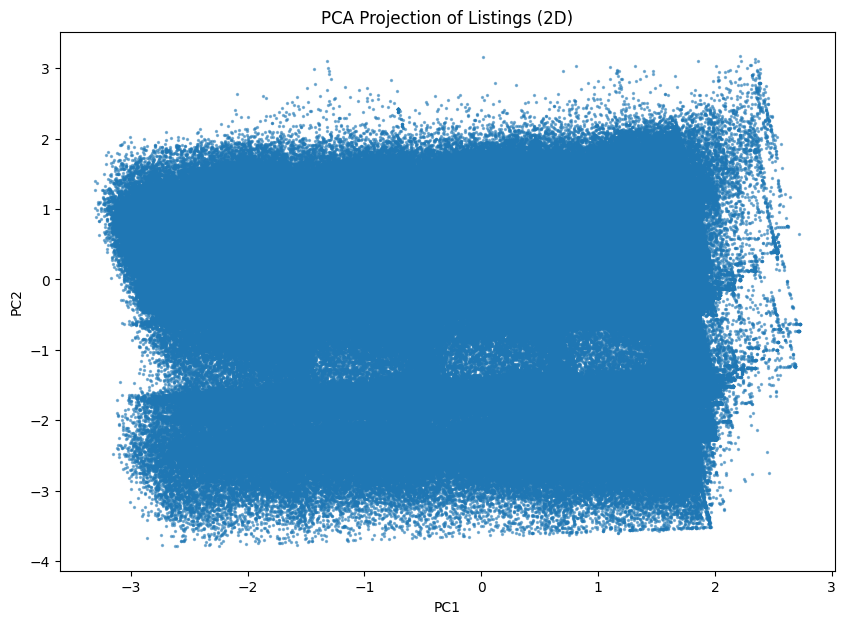

In [17]:
# --- STEP 3: PCA (Dimensionality Reduction) ---
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# --- Visualize 2D PCA projection ---
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=2, alpha=0.5)
plt.title("PCA Projection of Listings (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [18]:
# Features for geo-based clustering
geo_features = ['latitude', 'longitude', 'base_price', 'review_scores_rating']

X_geo = df_filtered[geo_features].dropna().copy()

# Scale all features for distance-based algorithms
scaler = StandardScaler()
X_geo_scaled = scaler.fit_transform(X_geo)

print(f"✅ Geo feature matrix shape: {X_geo_scaled.shape}")

✅ Geo feature matrix shape: (986250, 4)


Top 10 cities: ['Sicily', 'New Zealand', 'Puglia', 'Rio de Janeiro', 'Los Angeles', 'Rome', 'Hawaii', 'Buenos Aires', 'South Aegean', 'Ireland']

📍 Clustering 50891 listings in Sicily
🧭 Found 97 clusters in Sicily


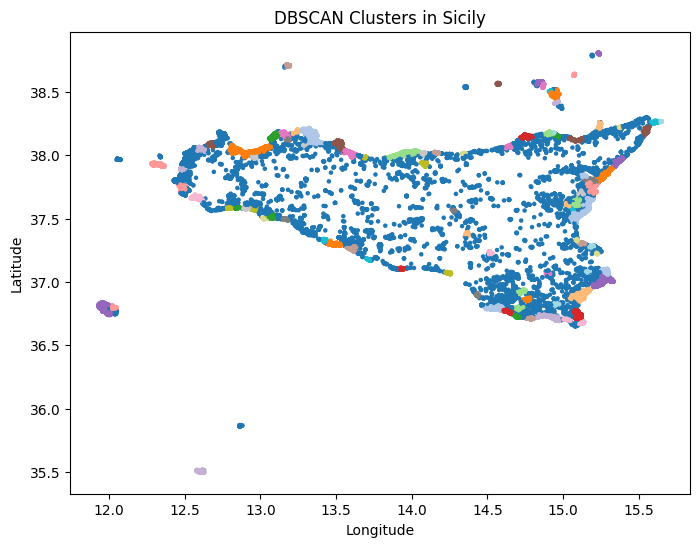


📍 Clustering 44295 listings in New Zealand
🧭 Found 93 clusters in New Zealand


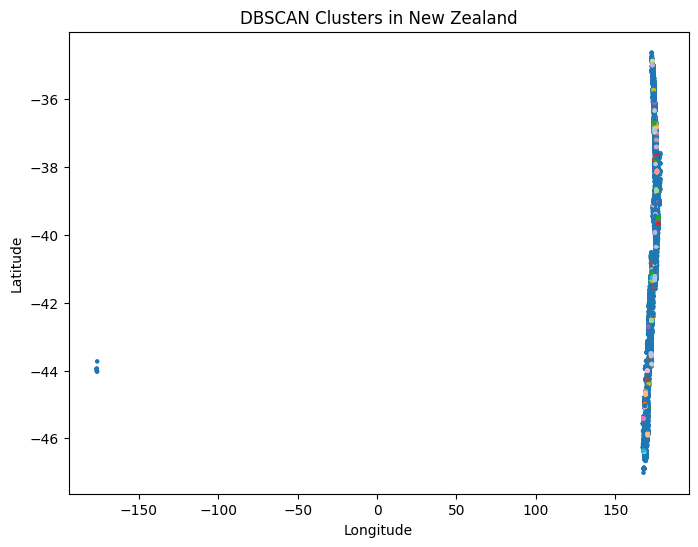


📍 Clustering 44013 listings in Puglia
🧭 Found 88 clusters in Puglia


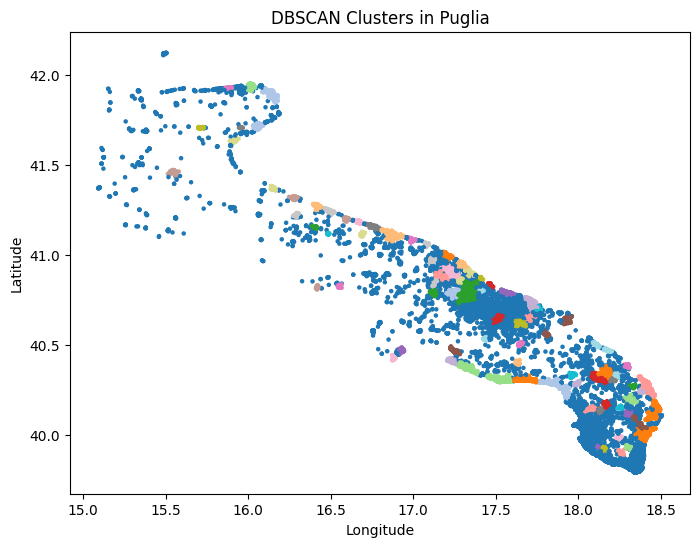


📍 Clustering 38749 listings in Rio de Janeiro
🧭 Found 6 clusters in Rio de Janeiro


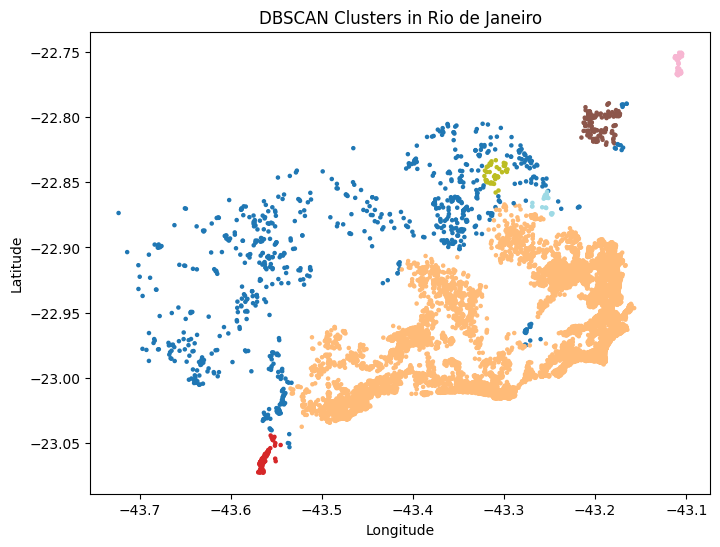


📍 Clustering 36624 listings in Los Angeles
🧭 Found 18 clusters in Los Angeles


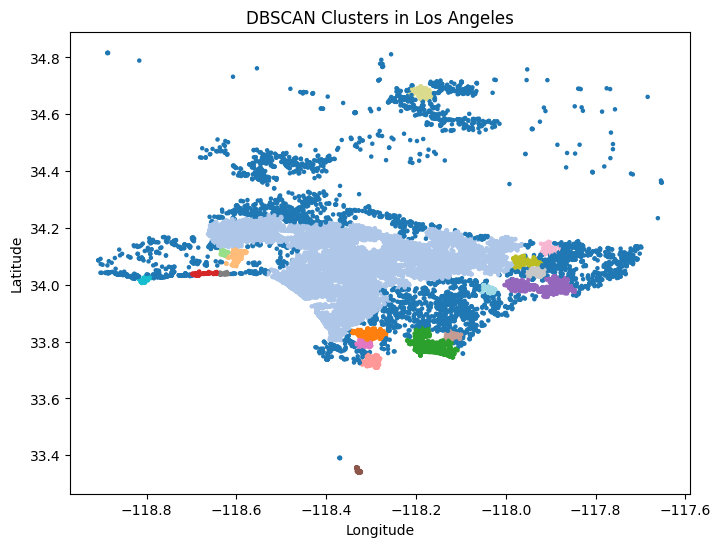


📍 Clustering 32219 listings in Rome
🧭 Found 4 clusters in Rome


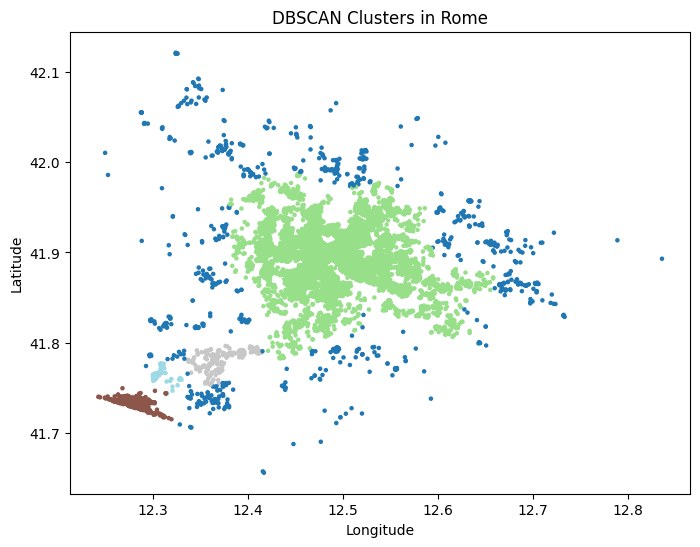


📍 Clustering 31831 listings in Hawaii
🧭 Found 36 clusters in Hawaii


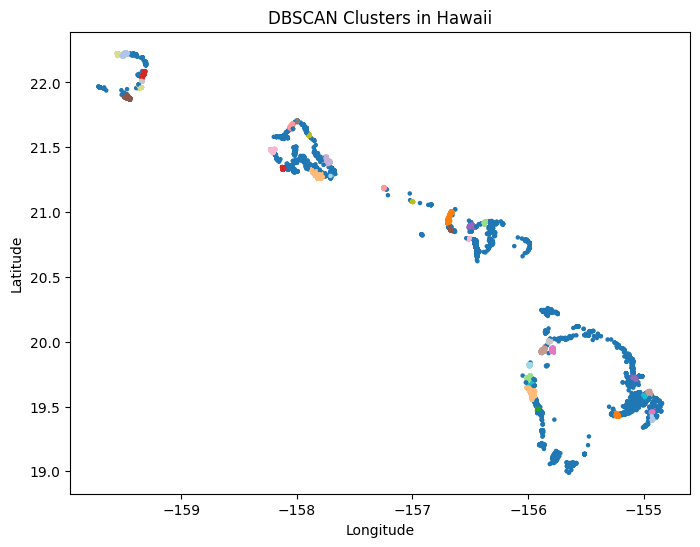


📍 Clustering 31407 listings in Buenos Aires
🧭 Found 1 clusters in Buenos Aires


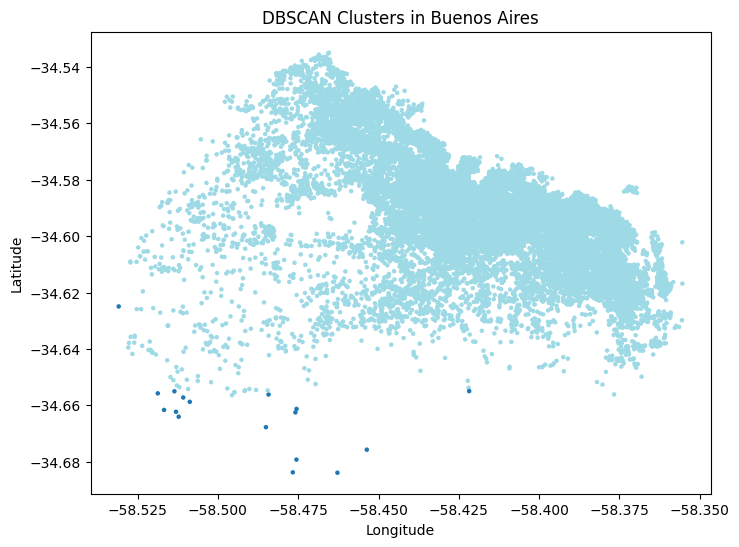


📍 Clustering 31286 listings in South Aegean
🧭 Found 59 clusters in South Aegean


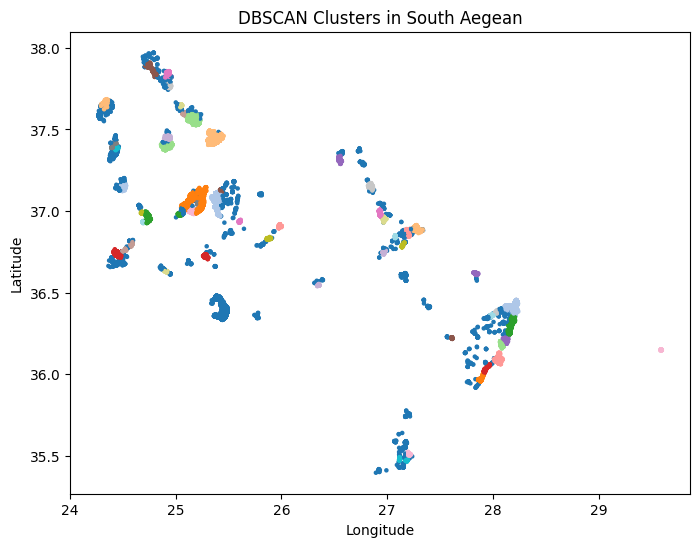


📍 Clustering 25551 listings in Ireland
🧭 Found 44 clusters in Ireland


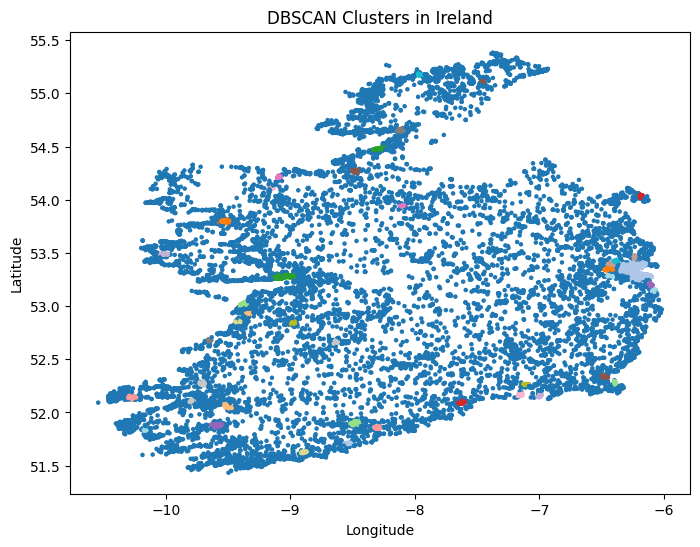

✅ Clustering completed for all top cities.


In [19]:
# Select top N cities by number of listings
top_n = 10
top_cities = df_filtered['property_city'].value_counts().head(top_n).index.tolist()
print(f"Top {top_n} cities: {top_cities}")

# Prepare a column for cluster labels
df_filtered['geo_cluster'] = -1  # -1 for noise/unclustered

# Loop through top cities and cluster each city separately
min_samples = 50
for city in top_cities:
    df_city = df_filtered[df_filtered['property_city'] == city].copy()
    print(f"\n📍 Clustering {len(df_city)} listings in {city}")

    # Convert latitude and longitude to radians
    coords = np.radians(df_city[['latitude', 'longitude']])
    
    # Estimate eps using k-distance plot (optional, here we pick a reasonable default)
    # eps ≈ 1.5 km for urban areas (convert to radians)
    eps_city = 1.5 / 6371

    # Run DBSCAN
    db = DBSCAN(eps=eps_city, min_samples=min_samples, metric='haversine').fit(coords)
    
    # Assign cluster labels back to main dataframe
    df_filtered.loc[df_city.index, 'geo_cluster'] = db.labels_
    
    # Quick summary
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    print(f"🧭 Found {n_clusters} clusters in {city}")

    # Optional: quick visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(df_city['longitude'], df_city['latitude'], c=db.labels_, cmap='tab20', s=5)
    plt.title(f"DBSCAN Clusters in {city}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

print("✅ Clustering completed for all top cities.")

In [20]:
for city in top_cities:
    city_data = df_filtered[df_filtered['property_city'] == city]
    n_clusters = len(set(city_data['geo_cluster'])) - (1 if -1 in city_data['geo_cluster'] else 0)
    print(f"{city}: {n_clusters} clusters found, {sum(city_data['geo_cluster'] == -1)} listings are noise")


Sicily: 98 clusters found, 7602 listings are noise
New Zealand: 94 clusters found, 14971 listings are noise
Puglia: 89 clusters found, 6028 listings are noise
Rio de Janeiro: 7 clusters found, 783 listings are noise
Los Angeles: 19 clusters found, 4429 listings are noise
Rome: 5 clusters found, 764 listings are noise
Hawaii: 37 clusters found, 2744 listings are noise
Buenos Aires: 2 clusters found, 17 listings are noise
South Aegean: 60 clusters found, 2513 listings are noise
Ireland: 45 clusters found, 16044 listings are noise


In [21]:
cluster_stats = df_filtered.groupby('geo_cluster').agg({
    'base_price': ['mean', 'median', 'count'],
    'number_of_reviews': ['mean', 'median'],
    'review_scores_rating': ['mean', 'median']
}).reset_index()

display(cluster_stats.head())


geo_cluster  base_price                number_of_reviews         \
                     mean median   count              mean median   
0          -1  454.141130  189.0  675279         46.717905   12.0   
1           0  532.372074  260.0  141289         38.631918   10.0   
2           1  273.061295  196.0    4617         39.931557    8.0   
3           2  187.294290  118.0   12977         33.282500    6.0   
4           3  341.960704  199.0   15294         29.720282    4.0   

  review_scores_rating         
                  mean median  
0             4.770957   4.86  
1             4.810776   4.90  
2             4.826097   4.89  
3             4.785286   4.90  
4             4.823299   4.90

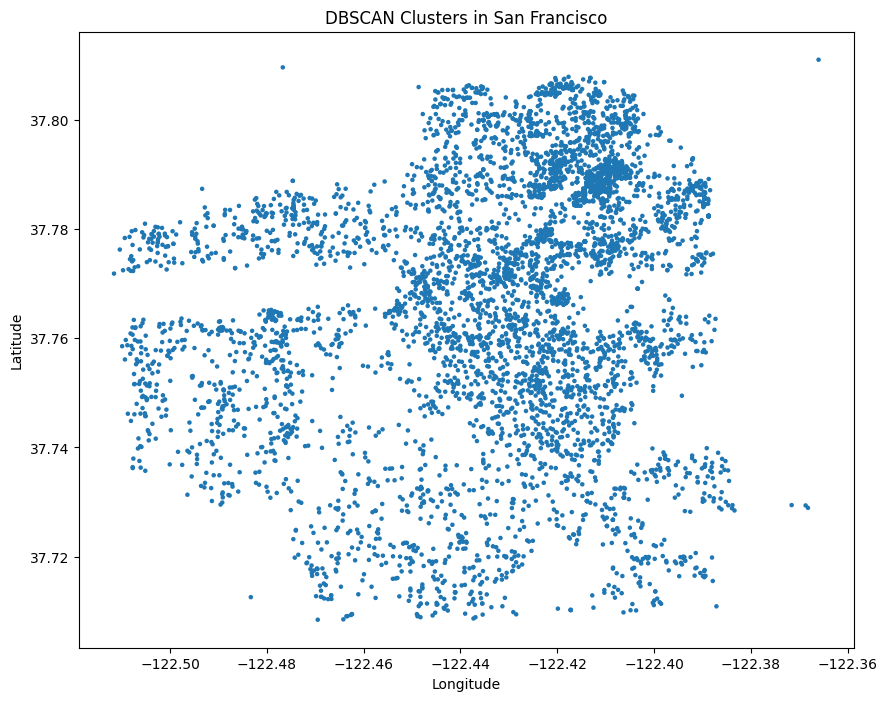

In [22]:
city = 'San Francisco'
city_data = df_filtered[df_filtered['property_city'] == city]

plt.figure(figsize=(10, 8))
plt.scatter(
    city_data['longitude'], city_data['latitude'],
    c=city_data['geo_cluster'], cmap='tab20', s=5
)
plt.title(f"DBSCAN Clusters in {city}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [28]:
# Group by city and cluster
cluster_summary = (
    df_filtered.groupby(['property_city', 'geo_cluster'])
    .agg(
        listings_count=('listing_id', 'count'),
        avg_price=('base_price', 'mean'),
        median_price=('base_price', 'median'),
        avg_reviews=('number_of_reviews', 'mean'),
        median_reviews=('number_of_reviews', 'median'),
        avg_rating=('review_scores_rating', 'mean'),
        median_rating=('review_scores_rating', 'median')
    )
    .reset_index()
)

# Calculate number of noise listings per city
noise_summary = (
    df_filtered[df_filtered['geo_cluster'] == -1]
    .groupby('property_city')
    .agg(noise_listings=('listing_id', 'count'))
    .reset_index()
)

# Merge noise info into cluster summary
cluster_summary = cluster_summary.merge(noise_summary, on='property_city', how='left')
cluster_summary['noise_listings'] = cluster_summary['noise_listings'].fillna(0).astype(int)

# Sort by city and cluster
cluster_summary = cluster_summary.sort_values(['property_city', 'geo_cluster'])

# Display top 20 rows
display(cluster_summary.head(20))


,property_city,geo_cluster,listings_count,avg_price,median_price,avg_reviews,median_reviews,avg_rating,median_rating,noise_listings
0,Albany,-1,425,111.378824,91.0,62.362353,20.0,4.728318,4.845,425
1,Amsterdam,-1,3462,261.808492,220.0,108.491046,28.0,4.837010,4.890,3462
2,Antwerp,-1,2287,122.218627,88.0,49.407958,18.0,4.652324,4.765,2287
3,Asheville,-1,1,89.000000,89.0,85.000000,85.0,4.960000,4.960,1
4,Athens,-1,14743,111.814895,76.0,54.404192,14.0,4.781261,4.870,14743
5,Bangkok,-1,22548,1118.279626,1335.0,22.766454,3.0,4.752242,4.850,22548
6,Barcelona,-1,4885,191.345957,144.0,74.209621,13.0,4.647564,4.720,4885
7,Barossa Valley,-1,315,372.431746,310.0,64.409524,23.0,4.851937,4.940,315
8,Barwon South West,-1,6211,359.972629,297.0,62.713090,20.0,4.804996,4.880,6211
9,Belize,-1,3018,411.880384,285.5,28.435719,9.0,4.798658,4.900,3018
